In [1]:
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns

from lifelines import KaplanMeierFitter as KM
from lifelines import CoxPHFitter as cox
from matplotlib import pyplot as plt
from pandas import DataFrame as df
from scipy import stats
from IPython.display import Image

import matplotlib
import matplotlib.font_manager as fm
from matplotlib.ft2font import FT2Font
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def get_font(*args, **kwargs):
    return FT2Font(*args, **kwargs)

fm.get_font = get_font

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
import gc
gc.collect()

20

# Global Paths

In [3]:
data_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/data/'
gsea_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/GSEA/'
result_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/results/'
panel_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/panels/Figure2/'

In [4]:
gene_sets = {}
with open(gsea_home + '/gene_sets/NREC_REC_91061.gmt', 'r') as f:
    for lines in f:
        lines = lines.rstrip().split('\t')
        gene_sets[lines[0]] = lines[2:]

In [5]:
ec_color = df(index=gene_sets['NREC_profile'] + gene_sets['REC_profile'], columns=['colors'])
ec_color.loc[gene_sets['NREC_profile'], 'colors'] = 'crimson'
ec_color.loc[gene_sets['REC_profile'], 'colors'] = 'royalblue'

# Figure Plan

    A: Venn diagram for overlap between CMAP2020 and NREC genes​

    B: Enrichment contrast of NREC and REC after genes in NREC are being knocked down (in melanoma)​

    C: Enrichment contrast of NREC and REC after genes in NREC are being knocked down (in other cancer types)​

    D: introduce shift ability, showing the distinct shift ability of shNRECgenes and shRECgenes (?)​

    E, F, G, H: 4 cases from D (?)​

    I: drugs targeting these genes (a transition from shRNAs to drug, may also be the figure 3A) 

In [6]:
shRNA_es_result = pd.read_csv(gsea_home + 'SKCM/shRNA_all_results/es_sorted_by_NREC.csv', header=0, index_col=0, sep=',')

In [7]:
shRNA_es_result

,NREC_profile,REC_profile,cmap_name
KDA002_A375_96H:H10,-0.418181,0.418882,FBP1
KDA002_A375_96H:TRCN0000050034:-666,-0.413904,0.395217,FBP1
KDC004_A375_96H:TRCN0000007400:-666,-0.406783,0.349941,ARHGEF6
KDB001_A375_96H:TRCN0000153171:-666,-0.404539,0.231638,TSPAN6
KDB004_A375_96H:TRCN0000082833:-666,-0.401795,0.347834,COL4A5
...,...,...,...
KDD006_A375_96H:TRCN0000006382:-666,0.351001,-0.327021,CRKL
KDB002_A375_96H:TRCN0000183104:-666,0.354830,-0.221236,ZNF395
TAK003_A375_96H:TRCN0000019413:-666,0.371441,-0.211632,STAT6
KDD001_A375_96H:TRCN0000195313:-666,0.374614,-0.397508,MYLK2


In [8]:
# L1000 gene info
bing_landmark = pd.read_csv(data_home + 'CMAP2020_Cancer/landmark_and_bings_L1000.csv',
                            header=0, index_col=0, sep=',', dtype={'Official NCBI gene symbol': 'str'}, converters={'Official NCBI gene symbol': None})
bing_landmark

,Official NCBI gene symbol
Official NCBI gene id,
5720,PSME1
7416,VDAC1
55847,CISD1
10174,SORBS3
25803,SPDEF
...,...
5137,PDE1C
51233,DRICH1
4340,MOG


In [9]:
skcm_sig_info = pd.read_csv(data_home + 'CMAP2020_Cancer/SKCM/skcm_2020_tash_sig_info.csv',
                            header=0, index_col=0, sep=',')

In [10]:
# shRNA perturbations that targeting these genes should be able to inhibit the expression of sig_defc_91061_up
## read original lv5 signature matrix
skcm_trt_sh_original = pd.read_csv(data_home + '/CMAP2020_Cancer/SKCM/CMAP2020_lv5_trt_sh_merged.csv',
                                   header=0, index_col=0, sep=',')
skcm_trt_sh_original.index = skcm_trt_sh_original.index.astype(int)
skcm_trt_sh_original = skcm_trt_sh_original[skcm_trt_sh_original.index.isin(bing_landmark.index)].rename(index=bing_landmark['Official NCBI gene symbol'])

In [11]:
skcm_trt_sh_original.shape

(10174, 2384)

## A. Venn diagram

In [14]:
# see the AACR poster

## B. NREC-REC shifting in shRNA experiments (A375-Melanoma)

In [12]:
# experiments directly targeting NREC and REC
tar_dir_EC = shRNA_es_result[shRNA_es_result['cmap_name'].isin(gene_sets['NREC_profile'] + gene_sets['REC_profile'])].index

In [13]:
# KO eff available
ko_eff = skcm_trt_sh_original[skcm_trt_sh_original.index.isin(df(shRNA_es_result.loc[tar_dir_EC, 'cmap_name'])['cmap_name'])].index

In [14]:
ko_eff_cal = df(index=tar_dir_EC, columns=['zexpr_lv5', 'gene'])
for exp in tar_dir_EC:
    ko_eff_cal.at[exp, 'zexpr_lv5'] = skcm_trt_sh_original.loc[shRNA_es_result.loc[exp, 'cmap_name'], exp]
    ko_eff_cal.at[exp, 'gene'] = shRNA_es_result.loc[exp, 'cmap_name']

In [15]:
# select the experiments with KO efficiency greater than 1.5 (z-score, decrease at 1.5 std)
top_ko_eff = ko_eff_cal[ko_eff_cal['zexpr_lv5'] <= -1]
top_ko_eff.shape

(209, 2)

In [16]:
top_ko_eff['NREC_enr'] = shRNA_es_result['NREC_profile']
top_ko_eff['REC_enr'] = shRNA_es_result['REC_profile']

<ipython-input-16-8291e3050352>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_ko_eff['NREC_enr'] = shRNA_es_result['NREC_profile']
<ipython-input-16-8291e3050352>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_ko_eff['REC_enr'] = shRNA_es_result['REC_profile']


In [17]:
top_ko_eff_nrec = top_ko_eff[top_ko_eff['gene'].isin(gene_sets['NREC_profile'])]
top_ko_eff_nrec

,zexpr_lv5,gene,NREC_enr,REC_enr
KDC006_A375_96H:TRCN0000029205:-666,-1.1519,PHB,-0.381665,0.316173
KDB010_A375_96H:TRCN0000010390:-666,-1.32921,MYC,-0.381145,0.222629
KDB005_A375_96H:TRCN0000004819:-666,-8.52316,HDAC2,-0.378953,0.198350
KDB005_A375_96H:TRCN0000019574:-666,-3.88597,MCM3,-0.377148,0.179115
KDB010_A375_96H:TRCN0000312581:-666,-1.06588,MYC,-0.376163,0.313916
...,...,...,...,...
KDB003_A375_96H:TRCN0000028541:-666,-4.02442,NNT,0.276859,-0.281090
KDD008_A375_96H:TRCN0000039662:-666,-1.99657,E2F1,0.294542,-0.222848
KDD008_A375_96H:TRCN0000039958:-666,-2.30255,CDK2,0.305766,-0.298304
KDA002_A375_96H:TRCN0000029389:-666,-1.19966,ANXA5,0.316787,-0.271774


In [18]:
top_ko_eff_rec = top_ko_eff[top_ko_eff['gene'].isin(gene_sets['REC_profile'])]
top_ko_eff_rec

,zexpr_lv5,gene,NREC_enr,REC_enr
KDA010_A375_96H:TRCN0000001353:-666,-1.15673,CLK4,-0.304691,0.307876
KDB008_A375_96H:TRCN0000064098:-666,-1.17438,LYRM1,-0.276762,-0.337061
KDB008_A375_96H:TRCN0000013696:-666,-1.98564,CEBPD,-0.273533,0.392424
KDB004_A375_96H:TRCN0000021064:-666,-1.05405,ID2,-0.247280,0.183500
KDA006_A375_96H:TRCN0000053212:-666,-5.15971,POLD4,-0.236578,-0.376319
KDB004_A375_96H:TRCN0000036226:-666,-4.80518,GLRX,0.160001,-0.230583
KDB002_A375_96H:TRCN0000151430:-666,-4.23442,DNAJC15,0.189001,-0.245026
KDD005_A375_96H:TRCN0000001387:-666,-2.07481,RPS6KA1,0.191081,-0.243350
TAK003_A375_96H:TRCN0000007229:-666,-1.66299,CFLAR,0.222092,-0.235790
KDB002_A375_96H:TRCN0000276361:-666,-4.02384,DNAJC15,0.224396,-0.301549


In [19]:
top_ko_eff.loc[top_ko_eff_nrec.index, 'EC_profile'] = 'crimson'
top_ko_eff.loc[top_ko_eff_rec.index, 'EC_profile'] = 'royalblue'

/home/dyang-server/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/dyang-server/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [20]:
top_ko_eff_merged = skcm_trt_sh_original[list(top_ko_eff_nrec.index) + list(top_ko_eff_rec.index)]

In [21]:
top_ko_eff_merged_ec = top_ko_eff_merged[top_ko_eff_merged.index.isin(gene_sets['NREC_profile'] + gene_sets['REC_profile'])]

In [22]:
top_ko_eff_merged_ec.shape

(1329, 209)

/home/dyang-server/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


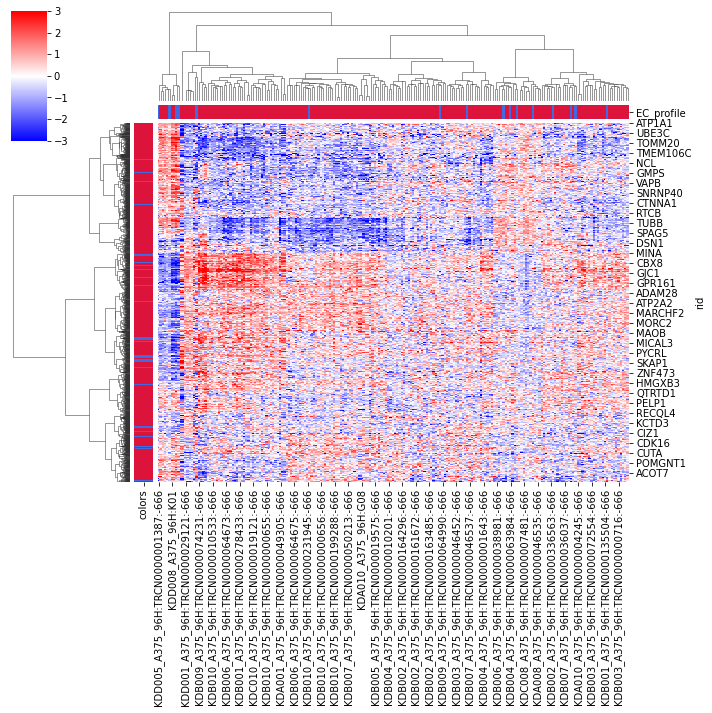

In [22]:
sns.clustermap(top_ko_eff_merged_ec,
               vmin=-3, vmax=3, cmap='bwr', method='ward',
               col_colors=top_ko_eff['EC_profile'],
               row_colors=ec_color['colors'])

In [23]:
# cluster within cols and rows for NREC
tmp_nrec = list(set(list(top_ko_eff_merged.index)) & set(gene_sets['NREC_profile']))
tmp_rec = list(set(list(top_ko_eff_merged.index)) & set(gene_sets['REC_profile']))

g_nrec = sns.clustermap(top_ko_eff_merged_ec.loc[tmp_nrec, top_ko_eff_nrec.index], method='ward')
g_nrec_col = [top_ko_eff_nrec.index[i] for i in g_nrec.dendrogram_col.reordered_ind]
g_nrec_row = [tmp_nrec[i] for i in g_nrec.dendrogram_row.reordered_ind]
plt.close()

g_rec = sns.clustermap(top_ko_eff_merged_ec.loc[tmp_rec, top_ko_eff_nrec.index], method='ward')
g_rec_row = [tmp_rec[i] for i in g_rec.dendrogram_row.reordered_ind]
plt.close()

g_rec = sns.clustermap(top_ko_eff_merged_ec.loc[tmp_nrec, top_ko_eff_rec.index], method='ward')
g_rec_col = [top_ko_eff_rec.index[i] for i in g_rec.dendrogram_col.reordered_ind]
plt.close()

/home/dyang-server/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


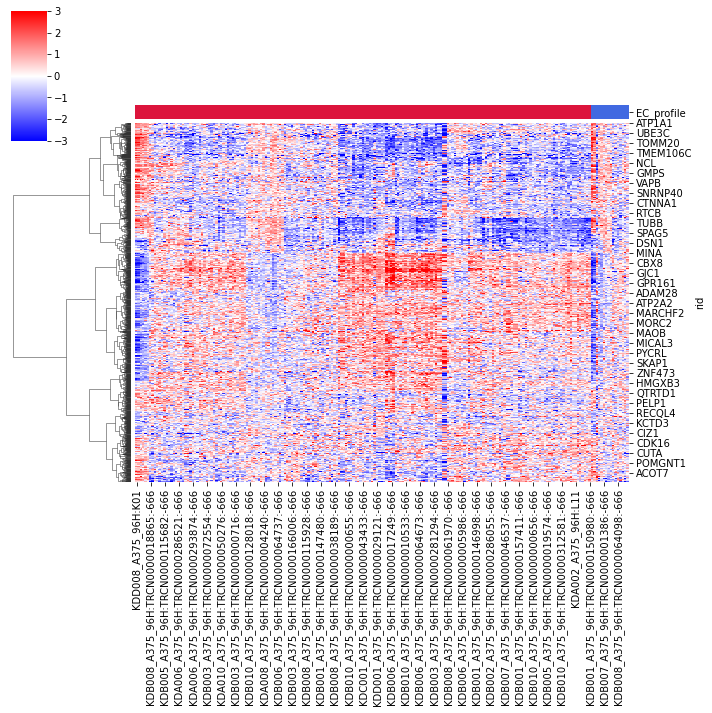

In [24]:
sns.clustermap(top_ko_eff_merged_ec[g_nrec_col + g_rec_col],
               vmin=-3, vmax=3, cmap='bwr', method='ward',
               col_cluster=False,
               col_colors=top_ko_eff['EC_profile'])

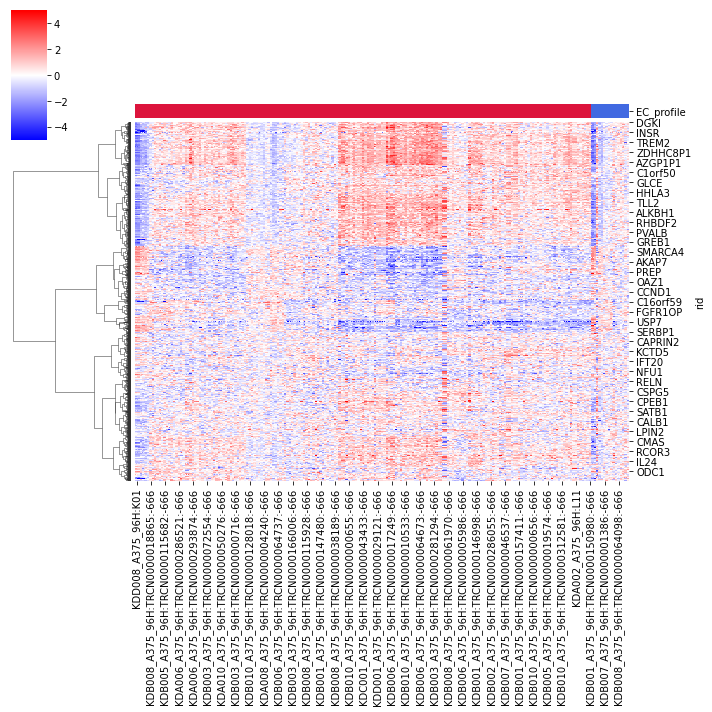

In [26]:
sns.clustermap(top_ko_eff_merged[g_nrec_col + g_rec_col],
               vmin=-5, vmax=5, cmap='bwr', method='ward',
               col_cluster=False,
               col_colors=top_ko_eff['EC_profile'])

In [25]:
top_ko_eff

,zexpr_lv5,gene,NREC_enr,REC_enr,EC_profile
KDC006_A375_96H:TRCN0000029205:-666,-1.1519,PHB,-0.381665,0.316173,crimson
KDB010_A375_96H:TRCN0000010390:-666,-1.32921,MYC,-0.381145,0.222629,crimson
KDB005_A375_96H:TRCN0000004819:-666,-8.52316,HDAC2,-0.378953,0.198350,crimson
KDB005_A375_96H:TRCN0000019574:-666,-3.88597,MCM3,-0.377148,0.179115,crimson
KDB010_A375_96H:TRCN0000312581:-666,-1.06588,MYC,-0.376163,0.313916,crimson
...,...,...,...,...,...
KDD008_A375_96H:TRCN0000039662:-666,-1.99657,E2F1,0.294542,-0.222848,crimson
KDD008_A375_96H:TRCN0000039958:-666,-2.30255,CDK2,0.305766,-0.298304,crimson
KDB007_A375_96H:TRCN0000001386:-666,-4.00117,RPS6KA1,0.314512,0.243508,royalblue
KDA002_A375_96H:TRCN0000029389:-666,-1.19966,ANXA5,0.316787,-0.271774,crimson


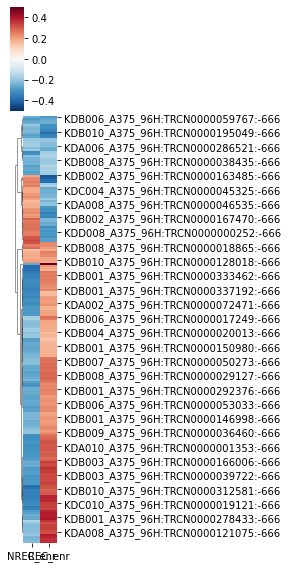

In [26]:
sns.clustermap(top_ko_eff[['NREC_enr', 'REC_enr']],
               figsize=(4, 8),
               row_cluster=True, col_cluster=False,
               cmap='RdBu_r', vmin=-.5, vmax=.5)

In [27]:
top_ko_eff.loc[top_ko_eff_nrec.index, :]

,zexpr_lv5,gene,NREC_enr,REC_enr,EC_profile
KDC006_A375_96H:TRCN0000029205:-666,-1.1519,PHB,-0.381665,0.316173,crimson
KDB010_A375_96H:TRCN0000010390:-666,-1.32921,MYC,-0.381145,0.222629,crimson
KDB005_A375_96H:TRCN0000004819:-666,-8.52316,HDAC2,-0.378953,0.198350,crimson
KDB005_A375_96H:TRCN0000019574:-666,-3.88597,MCM3,-0.377148,0.179115,crimson
KDB010_A375_96H:TRCN0000312581:-666,-1.06588,MYC,-0.376163,0.313916,crimson
...,...,...,...,...,...
KDB003_A375_96H:TRCN0000028541:-666,-4.02442,NNT,0.276859,-0.281090,crimson
KDD008_A375_96H:TRCN0000039662:-666,-1.99657,E2F1,0.294542,-0.222848,crimson
KDD008_A375_96H:TRCN0000039958:-666,-2.30255,CDK2,0.305766,-0.298304,crimson
KDA002_A375_96H:TRCN0000029389:-666,-1.19966,ANXA5,0.316787,-0.271774,crimson


In [28]:
top_ko_eff.loc[top_ko_eff_rec.index, :]

,zexpr_lv5,gene,NREC_enr,REC_enr,EC_profile
KDA010_A375_96H:TRCN0000001353:-666,-1.15673,CLK4,-0.304691,0.307876,royalblue
KDB008_A375_96H:TRCN0000064098:-666,-1.17438,LYRM1,-0.276762,-0.337061,royalblue
KDB008_A375_96H:TRCN0000013696:-666,-1.98564,CEBPD,-0.273533,0.392424,royalblue
KDB004_A375_96H:TRCN0000021064:-666,-1.05405,ID2,-0.247280,0.183500,royalblue
KDA006_A375_96H:TRCN0000053212:-666,-5.15971,POLD4,-0.236578,-0.376319,royalblue
KDB004_A375_96H:TRCN0000036226:-666,-4.80518,GLRX,0.160001,-0.230583,royalblue
KDB002_A375_96H:TRCN0000151430:-666,-4.23442,DNAJC15,0.189001,-0.245026,royalblue
KDD005_A375_96H:TRCN0000001387:-666,-2.07481,RPS6KA1,0.191081,-0.243350,royalblue
TAK003_A375_96H:TRCN0000007229:-666,-1.66299,CFLAR,0.222092,-0.235790,royalblue
KDB002_A375_96H:TRCN0000276361:-666,-4.02384,DNAJC15,0.224396,-0.301549,royalblue


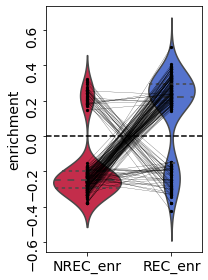

In [205]:
plt.figure(figsize=(3, 4))
sns.violinplot(x='variable', y='value',
               inner='quartile',
               data=pd.melt(top_ko_eff.loc[top_ko_eff_nrec.index, ['NREC_enr', 'REC_enr']]),
               palette={'NREC_enr': 'crimson', 'REC_enr': 'royalblue'})

plt.scatter(np.zeros(len(top_ko_eff_nrec.index)), top_ko_eff.loc[top_ko_eff_nrec.index, 'NREC_enr'], s=5, c='k')
plt.scatter(np.ones(len(top_ko_eff_nrec.index)), top_ko_eff.loc[top_ko_eff_nrec.index, 'REC_enr'], s=5, c='k')
for i in top_ko_eff_nrec.index:
    plt.plot([0, 1], [top_ko_eff.loc[i, 'NREC_enr'], top_ko_eff.loc[i, 'REC_enr']], c='k', linewidth=0.2)

plt.axhline(y=0., c='k', ls='--')
plt.ylabel('enrichment', fontsize=14)
plt.xlabel('')
plt.yticks(rotation=90, fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()
fig = plt.gcf()
fig.savefig(panel_home + '/direct_target_A375/NREC_targeted.png', transparent=True, dpi=300)
fig.savefig(panel_home + '/direct_target_A375/NREC_targeted.pdf', transparent=True)

In [29]:
stats.ttest_rel(top_ko_eff_nrec['NREC_enr'], top_ko_eff_nrec['REC_enr'])

Ttest_relResult(statistic=-11.35369573953386, pvalue=3.460152766764867e-23)

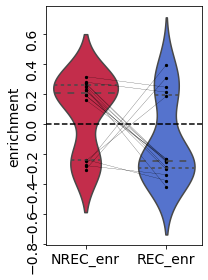

In [206]:
plt.figure(figsize=(3, 4))
sns.violinplot(x='variable', y='value',
               inner='quartile',
               data=pd.melt(top_ko_eff.loc[top_ko_eff_rec.index, ['NREC_enr', 'REC_enr']]),
               palette={'NREC_enr': 'crimson', 'REC_enr': 'royalblue'})

plt.scatter(np.zeros(len(top_ko_eff_rec.index)), top_ko_eff.loc[top_ko_eff_rec.index, 'NREC_enr'], s=5, c='k')
plt.scatter(np.ones(len(top_ko_eff_rec.index)), top_ko_eff.loc[top_ko_eff_rec.index, 'REC_enr'], s=5, c='k')
for i in top_ko_eff_rec.index:
    plt.plot([0, 1], [top_ko_eff.loc[i, 'NREC_enr'], top_ko_eff.loc[i, 'REC_enr']], c='k', linewidth=0.2)

plt.axhline(y=0., c='k', ls='--')
plt.ylabel('enrichment', fontsize=14)
plt.xlabel('')
plt.yticks(rotation=90, fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()
fig = plt.gcf()
fig.savefig(panel_home + '/direct_target_A375/REC_targeted.png', transparent=True, dpi=300)
fig.savefig(panel_home + '/direct_target_A375/REC_targeted.pdf', transparent=True)

In [30]:
stats.ttest_rel(top_ko_eff_rec['NREC_enr'], top_ko_eff_rec['REC_enr'])

Ttest_relResult(statistic=1.8299005204110106, pvalue=0.08720842934228214)

## D. Shift ability (important)

In [31]:
shRNA_es_result

,NREC_profile,REC_profile,cmap_name
KDA002_A375_96H:H10,-0.418181,0.418882,FBP1
KDA002_A375_96H:TRCN0000050034:-666,-0.413904,0.395217,FBP1
KDC004_A375_96H:TRCN0000007400:-666,-0.406783,0.349941,ARHGEF6
KDB001_A375_96H:TRCN0000153171:-666,-0.404539,0.231638,TSPAN6
KDB004_A375_96H:TRCN0000082833:-666,-0.401795,0.347834,COL4A5
...,...,...,...
KDD006_A375_96H:TRCN0000006382:-666,0.351001,-0.327021,CRKL
KDB002_A375_96H:TRCN0000183104:-666,0.354830,-0.221236,ZNF395
TAK003_A375_96H:TRCN0000019413:-666,0.371441,-0.211632,STAT6
KDD001_A375_96H:TRCN0000195313:-666,0.374614,-0.397508,MYLK2


In [32]:
shRNA_shift = shRNA_es_result.copy()
shRNA_shift['original'] = shRNA_shift['NREC_profile'] - shRNA_shift['REC_profile']
shRNA_shift['modified'] = shRNA_shift['REC_profile'] - shRNA_shift['NREC_profile'] # just the reverse of original

In [33]:
shRNA_shift

,NREC_profile,REC_profile,cmap_name,original,modified
KDA002_A375_96H:H10,-0.418181,0.418882,FBP1,-0.837063,0.837063
KDA002_A375_96H:TRCN0000050034:-666,-0.413904,0.395217,FBP1,-0.809121,0.809121
KDC004_A375_96H:TRCN0000007400:-666,-0.406783,0.349941,ARHGEF6,-0.756723,0.756723
KDB001_A375_96H:TRCN0000153171:-666,-0.404539,0.231638,TSPAN6,-0.636177,0.636177
KDB004_A375_96H:TRCN0000082833:-666,-0.401795,0.347834,COL4A5,-0.749630,0.749630
...,...,...,...,...,...
KDD006_A375_96H:TRCN0000006382:-666,0.351001,-0.327021,CRKL,0.678023,-0.678023
KDB002_A375_96H:TRCN0000183104:-666,0.354830,-0.221236,ZNF395,0.576066,-0.576066
TAK003_A375_96H:TRCN0000019413:-666,0.371441,-0.211632,STAT6,0.583072,-0.583072
KDD001_A375_96H:TRCN0000195313:-666,0.374614,-0.397508,MYLK2,0.772121,-0.772121


In [34]:
top_ko_shRNA_shift = shRNA_shift[shRNA_shift.index.isin(top_ko_eff.index)]

/home/dyang-server/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


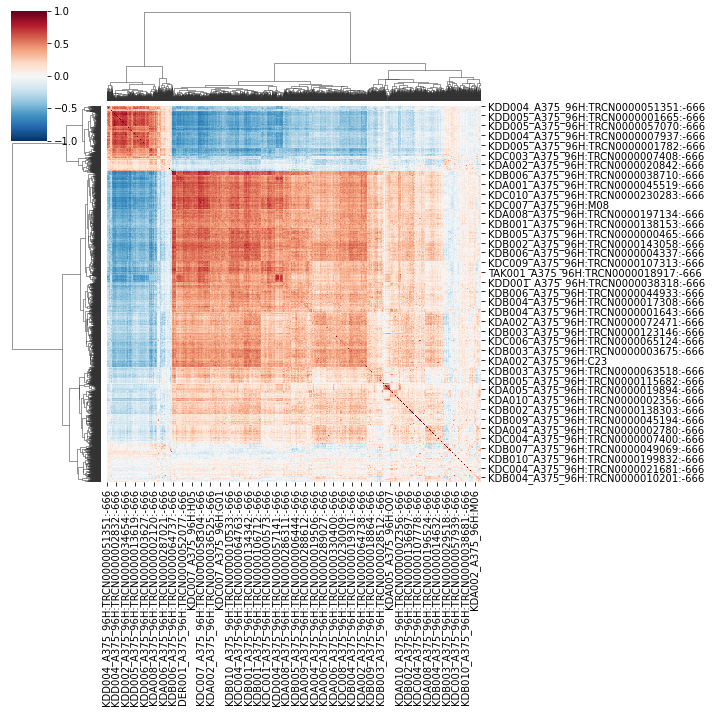

In [155]:
sns.clustermap(skcm_trt_sh_original.corr(), vmin=-1, vmax=1, cmap='RdBu_r')

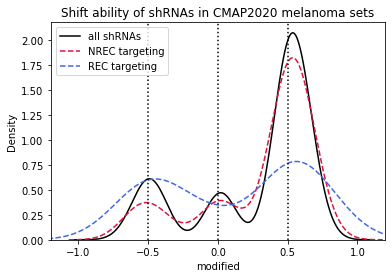

In [211]:
plt.figure(figsize=(6, 4))
sns.kdeplot(x='modified', data=shRNA_shift, label='all shRNAs', c='k')
sns.kdeplot(x='modified', data=shRNA_shift[shRNA_shift['cmap_name'].isin(gene_sets['NREC_profile'])], label='NREC targeting', c='crimson', ls='--')
sns.kdeplot(x='modified', data=shRNA_shift[shRNA_shift['cmap_name'].isin(gene_sets['REC_profile'])], label='REC targeting', c='royalblue', ls='--')
plt.title('Shift ability of shRNAs in CMAP2020 melanoma sets')
plt.axvline(x=-.5, ls=':', c='k')
plt.axvline(x=.5, ls=':', c='k')
plt.axvline(x=0, ls=':', c='k')
plt.xlim(-1.2, 1.2)
plt.legend()

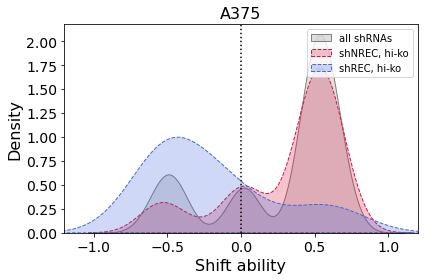

In [212]:
plt.figure(figsize=(6, 4))
sns.kdeplot(x='modified', data=shRNA_shift,
            # cumulative=True,
            label='all shRNAs', fill=True, color='grey')
# sns.rugplot(x='modified', data=shRNA_shift, color='grey')
sns.kdeplot(x='modified', data=shRNA_shift[shRNA_shift.index.isin(top_ko_eff_nrec.index)],
            # cumulative=True,
            label='shNREC, hi-ko', fill=True, color='crimson', ls='--')
# sns.rugplot(x='modified', data=shRNA_shift[shRNA_shift.index.isin(top_ko_eff_nrec.index)], color='crimson')
sns.kdeplot(x='modified', data=shRNA_shift[shRNA_shift.index.isin(top_ko_eff_rec.index)],
            # cumulative=True,
            label='shREC, hi-ko', fill=True, color='royalblue', ls='--')
# sns.rugplot(x='modified', data=shRNA_shift[shRNA_shift.index.isin(top_ko_eff_rec.index)], color='royalblue')
plt.title('A375', fontsize=16)
plt.xlabel('Shift ability', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.axvline(x=0, ls=':', c='k')
plt.xlim(-1.2, 1.2)
plt.legend()
plt.yticks(rotation=0, fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()
fig = plt.gcf()
fig.savefig(panel_home + '/shift_ability/A375.png', transparent=True, dpi=300)
fig.savefig(panel_home + '/shift_ability/A375.pdf', transparent=True)

In [40]:
stats.ks_2samp(shRNA_shift[shRNA_shift.index.isin(top_ko_eff_nrec.index)]['modified'],
               shRNA_shift[shRNA_shift.index.isin(top_ko_eff_rec.index)]['modified'])

KstestResult(statistic=0.657059585492228, pvalue=1.0937217510553765e-06)

In [39]:
shRNA_shift

,NREC_profile,REC_profile,cmap_name,original,modified
KDA002_A375_96H:H10,-0.418181,0.418882,FBP1,-0.837063,0.837063
KDA002_A375_96H:TRCN0000050034:-666,-0.413904,0.395217,FBP1,-0.809121,0.809121
KDC004_A375_96H:TRCN0000007400:-666,-0.406783,0.349941,ARHGEF6,-0.756723,0.756723
KDB001_A375_96H:TRCN0000153171:-666,-0.404539,0.231638,TSPAN6,-0.636177,0.636177
KDB004_A375_96H:TRCN0000082833:-666,-0.401795,0.347834,COL4A5,-0.749630,0.749630
...,...,...,...,...,...
KDD006_A375_96H:TRCN0000006382:-666,0.351001,-0.327021,CRKL,0.678023,-0.678023
KDB002_A375_96H:TRCN0000183104:-666,0.354830,-0.221236,ZNF395,0.576066,-0.576066
TAK003_A375_96H:TRCN0000019413:-666,0.371441,-0.211632,STAT6,0.583072,-0.583072
KDD001_A375_96H:TRCN0000195313:-666,0.374614,-0.397508,MYLK2,0.772121,-0.772121


In [214]:
top_ko_shRNA_shift.loc[top_ko_eff_nrec.index, 'EC_profile'] = 'shNREC'
top_ko_shRNA_shift.loc[top_ko_eff_rec.index, 'EC_profile'] = 'shREC'

/home/dyang-server/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/dyang-server/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


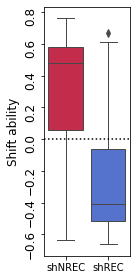

In [215]:
plt.figure(figsize=(2, 4))
sns.boxplot(x='EC_profile', y='modified', data=top_ko_shRNA_shift,
            palette={'shNREC': 'crimson', 'shREC': 'royalblue'},
            linewidth=1)
plt.xlabel('')
plt.ylabel('Shift ability', fontsize=12)
plt.yticks(rotation=90, fontsize=12)
plt.axhline(y=0., c='k', ls=':')
plt.tight_layout()
fig = plt.gcf()
fig.savefig(panel_home + '/shift_ability/A375_boxplot.png', transparent=True, dpi=300)
fig.savefig(panel_home + '/shift_ability/A375_boxplot.pdf', transparent=True)

In [ ]:
# top shift candidates heatmap
